# Finanzas Computacionales
## Proyecto individual
### Profesor: Dr. Luis Vicente Montiel Cendejas
### Estudiante: Eduardo Selim Martínez Mayorga
### ID: 405017834
### Fecha de entrega: 10 de Mayo de 2022

# Librerías

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
from functools import lru_cache
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
TRADING_DAYS = 252  # días hábiles por año

# Descargar datos de Yahoo Finance

In [3]:

@lru_cache(maxsize=128)
def _download_close_cached(tickers_tuple, start, end, auto_adjust=True):
    tickers = list(tickers_tuple)

    data = yf.download(
        tickers,
        start=start,
        end=end,
        progress=False,
        auto_adjust=auto_adjust,
        group_by="column",
    )

    # Caso MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        if "Close" in data.columns.get_level_values(0):
            close = data["Close"].copy()
        elif "Adj Close" in data.columns.get_level_values(0):
            close = data["Adj Close"].copy()
        else:
            raise KeyError("No encontré 'Close' ni 'Adj Close' en columnas MultiIndex.")

    # Caso SingleIndex
    else:
        if "Close" in data.columns:
            close = data[["Close"]].copy()
        elif "Adj Close" in data.columns:
            close = data[["Adj Close"]].copy()
        else:
            raise KeyError("No encontré 'Close' ni 'Adj Close' en columnas.")

        if len(tickers) == 1:
            close.columns = [tickers[0]]

    if isinstance(close, pd.Series):
        close = close.to_frame(name=tickers[0])

    close = close.dropna(how="all")
    return close


def get_close(tickers, fecha_inicio, fecha_fin, auto_adjust=True):
    if isinstance(tickers, str):
        tickers = [tickers]

    close = _download_close_cached(tuple(tickers), fecha_inicio, fecha_fin, auto_adjust=auto_adjust)

    missing = [t for t in tickers if t not in close.columns]
    if missing:
        raise KeyError(f"Faltan columnas para tickers: {missing}. Columnas disponibles: {list(close.columns)}")

    return close[tickers]


def returns_from_close(close: pd.DataFrame, kind="log"):
    close = close.dropna(how="any")
    if kind == "log":
        rets = np.log(close).diff()
    else:
        rets = close.pct_change()
    return rets.dropna(how="any")

# Estimadores 

In [5]:
def calcula_media(ticker, fecha_inicio, fecha_fin, kind="log"):
    close = get_close(ticker, fecha_inicio, fecha_fin)[ticker]
    rets = returns_from_close(close.to_frame("x"), kind=kind)["x"]
    return float(rets.mean())  # media por día 


def calcula_desv_est(ticker, fecha_inicio, fecha_fin, kind="log", ddof=1):
    close = get_close(ticker, fecha_inicio, fecha_fin)[ticker]
    rets = returns_from_close(close.to_frame("x"), kind=kind)["x"]
    return float(rets.std(ddof=ddof))  # sigma por día 


def calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin, kind="log"):
    close = get_close([ticker1, ticker2], fecha_inicio, fecha_fin)[[ticker1, ticker2]]
    rets = returns_from_close(close, kind=kind)
    return float(rets.corr().iloc[0, 1])


def ultimo_precio(ticker, fecha_inicio, fecha_fin):
    close = get_close(ticker, fecha_inicio, fecha_fin)[ticker]
    return float(close.iloc[-1])

#  BINOMIAL AMERICANA (sola)

In [6]:
def arbol_americano(ticker, fecha_inicio, fecha_fin, K, T_years, r, N, tipo="put",
                   returns_kind="log"):
    sigma_daily = calcula_desv_est(ticker, fecha_inicio, fecha_fin, kind=returns_kind, ddof=1)
    sigma = sigma_daily * np.sqrt(TRADING_DAYS)  # anual

    dt = T_years / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    S0 = ultimo_precio(ticker, fecha_inicio, fecha_fin)

    j = np.arange(N + 1)
    S_T = S0 * (u ** j) * (d ** (N - j))

    V = np.maximum(S_T - K, 0.0) if tipo == "call" else np.maximum(K - S_T, 0.0)

    for i in range(N - 1, -1, -1):
        j = np.arange(i + 1)
        S_i = S0 * (u ** j) * (d ** (i - j))
        V = disc * (p * V[1:] + (1 - p) * V[:-1])
        V = np.maximum(V, S_i - K) if tipo == "call" else np.maximum(V, K - S_i)

    return float(V[0])

# BINOMIAL AMERICANA (portafolio)

In [7]:
def arbol_americano_portafolio(ticker1, ticker2, w, fecha_inicio, fecha_fin, K, T_years, r, N,
                               tipo="call", returns_kind="log"):
    sig1_daily = calcula_desv_est(ticker1, fecha_inicio, fecha_fin, kind=returns_kind, ddof=1)
    sig2_daily = calcula_desv_est(ticker2, fecha_inicio, fecha_fin, kind=returns_kind, ddof=1)
    sig1 = sig1_daily * np.sqrt(TRADING_DAYS)
    sig2 = sig2_daily * np.sqrt(TRADING_DAYS)
    rho = calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin, kind=returns_kind)

    sigmaP = math.sqrt((w**2) * (sig1**2) + ((1-w)**2) * (sig2**2) + 2*w*(1-w)*rho*sig1*sig2)

    dt = T_years / N
    u = np.exp(sigmaP * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    S01 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
    S02 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
    S0 = w * S01 + (1 - w) * S02

    j = np.arange(N + 1)
    S_T = S0 * (u ** j) * (d ** (N - j))
    V = np.maximum(S_T - K, 0.0) if tipo == "call" else np.maximum(K - S_T, 0.0)

    for i in range(N - 1, -1, -1):
        j = np.arange(i + 1)
        S_i = S0 * (u ** j) * (d ** (i - j))
        V = disc * (p * V[1:] + (1 - p) * V[:-1])
        V = np.maximum(V, S_i - K) if tipo == "call" else np.maximum(V, K - S_i)

    return float(V[0])

# PAYOFFS (sin globals)

In [8]:
def payoff_call(S, K):
    return np.maximum(S - K, 0.0)

def payoff_put(S, K):
    return np.maximum(K - S, 0.0)

# SIMULACIÓN GBM (1 activo) CON MU HISTÓRICA (P)

El modelo buscamos simular es el movimiento browniano geométrico (GBM):

$ dS_t = \mu S_t\,dt + \sigma S_t\,dW_t. $

La discretización para un paso de tamaño $\Delta t$ es:

$ S_{t+\Delta t} = S_t \exp\!\left( (\mu - \tfrac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z \right), \qquad Z\sim N(0,1). $

Por lo que tenemos dos factores indispensables:
- El **drift** se multiplica por $\Delta t$.
- El **término aleatorio** (browniano) se multiplica por $\sqrt{\Delta t}$.

En el código se construye $W$ como una suma acumulada de normales estándar, $W=\sum Z$, y luego se usa
$ S \approx S_0\exp(\text{drift} + \sigma W) $,
lo cual equivale a asumir implícitamente $\Delta t = 1$ (un paso de “tamaño 1”) y además deja el parámetro `dt` sin afectar realmente la escala del proceso. Esto puede mezclar unidades (por ejemplo, interpretar $T=252/2$ como días mientras el proceso usa pasos de tamaño 1 sin conversion).

La corrección consiste en introducir explícitamente el tamaño del paso:
si el paso es de `dt_days` días y se trabaja en años, entonces
$ \Delta t = \frac{\text{dt\_days}}{252}. $
Con esto, la simulación correcta usa:
$ S_{k+1} = S_k \exp\!\left( (\mu - \tfrac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z_k \right). $

Así, al cambiar `dt_days` o el horizonte `T_days`, el modelo se escala correctamente y las unidades de $\mu$, $\sigma$ y el descuento (por ejemplo con $e^{-r\Delta t}$) quedan consistentes.

In [ ]:
def genera_simulaciones_individual(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    returns_kind="log",
    seed=None
):
    """
    Simula GBM con drift = mu histórica (medida P).
    - dt_days: paso en días (1 diario)
    - T_days: horizonte total en días (ej. 252/2)
    Retorna array (num_sims, steps+1) incluyendo S0.
    """
    rng = np.random.default_rng(seed)

    close = get_close(ticker1, fecha_inicio, fecha_fin)[ticker1]
    rets = returns_from_close(close.to_frame("x"), kind=returns_kind)["x"]

    mu_daily = float(rets.mean())
    sig_daily = float(rets.std(ddof=1))
    S0 = float(close.iloc[-1])

    steps = int(T_days / dt_days)
    dt = dt_days / TRADING_DAYS  # años por paso

    # Se anualiza para usar fórmula continua anual
    mu_annual = mu_daily * TRADING_DAYS
    sig_annual = sig_daily * np.sqrt(TRADING_DAYS)

    Z = rng.normal(size=(num_sims, steps))
    inc = (mu_annual - 0.5 * sig_annual**2) * dt + sig_annual * np.sqrt(dt) * Z

    logS = np.log(S0) + np.cumsum(inc, axis=1)
    S = np.exp(logS)

    S = np.concatenate([np.full((num_sims, 1), S0), S], axis=1)
    return S


def genera_df_simulaciones(ticker1, fecha_inicio, fecha_fin, num_sims, dt_days, T_days,
                          returns_kind="log", seed=None):
    trayectorias = genera_simulaciones_individual(
        ticker1, fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        returns_kind=returns_kind, seed=seed
    )
    steps = trayectorias.shape[1] - 1
    df = pd.DataFrame(trayectorias[:, 1:])
    df.columns = [str(i) for i in range(1, steps + 1)]
    return df

# LONGSTAFF–SCHWARTZ (1 activo)

In [10]:
def ejercicio_americana_LS(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    returns_kind="log",
    seed=None,
    min_itm=25
):
    """
    Devuelve [lst, df] como tú.
    - df: sims x steps (sin S0) con columnas "1"... "steps"
    - lst: lista de listas de índices ejercidos (se arma hacia atrás como tu lógica)
    """
    df = genera_df_simulaciones(
        ticker1, fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        returns_kind=returns_kind, seed=seed
    )

    steps = df.shape[1]
    dt = dt_days / TRADING_DAYS
    disc = np.exp(-r * dt)

    paths = df.to_numpy()
    alive = np.ones(num_sims, dtype=bool)

    # payoff al vencimiento
    cf = funcion_payoff(paths[:, -1], K).astype(float)

    lst = []
    lst.append(np.where((cf > 0) & alive)[0].tolist())

    # backward t = steps-1 ... 1
    for t in range(steps - 1, 0, -1):
        cf_disc = cf * disc
        S_t = paths[:, t - 1]
        intrinsic = funcion_payoff(S_t, K).astype(float)
        eligible = alive & (intrinsic > 0)

        if eligible.sum() < min_itm:
            cf = cf_disc
            lst.append([])
            continue

        X = S_t[eligible].reshape(-1, 1)
        Y = cf_disc[eligible].reshape(-1, 1)

        polin = PolynomialFeatures(degree=grados_pasado, include_bias=True)
        Xp = polin.fit_transform(X)

        reg = LinearRegression().fit(Xp, Y)
        cont = reg.predict(Xp).flatten()

        ex = intrinsic[eligible] >= cont
        idx_eligible = np.where(eligible)[0]
        idx_ex = idx_eligible[ex]

        cf = cf_disc.copy()
        cf[idx_ex] = intrinsic[idx_ex]
        alive[idx_ex] = False

        lst.append(idx_ex.tolist())

    return [lst, df]


def obtiene_estrategia_LS(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    returns_kind="log",
    seed=None
):
    lst, df = ejercicio_americana_LS(
        ticker1, fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, returns_kind=returns_kind, seed=seed
    )

    num_cols = df.shape[1]
    lst = list(reversed(lst))  # orden temporal

    df_estrategia = np.zeros((num_sims, num_cols), dtype=int)
    for j in range(num_cols):
        idx = lst[j] if j < len(lst) else []
        if idx:
            df_estrategia[idx, j] = 1

    lista_fechas_ejercicio = []
    for i in range(num_sims):
        row = df_estrategia[i, :]
        if row.sum() == 0:
            lista_fechas_ejercicio.append(-1)
        else:
            lista_fechas_ejercicio.append(int(np.argmax(row)))

    return [lista_fechas_ejercicio, df]


def calcula_precio_americana(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    returns_kind="log",
    seed=None
):
    lista_fechas_ejercicio, df = obtiene_estrategia_LS(
        ticker1, fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, returns_kind=returns_kind, seed=seed
    )

    dt = dt_days / TRADING_DAYS

    payoff_ejercicio = np.zeros(num_sims, dtype=float)
    for i in range(num_sims):
        t_idx = lista_fechas_ejercicio[i]
        if t_idx < 0:
            payoff_ejercicio[i] = 0.0
        else:
            S_ex = float(df.iloc[i, t_idx])
            payoff_ejercicio[i] = float(funcion_payoff(S_ex, K)) * math.exp(-r * (t_idx + 1) * dt)

    estrategia_ejercicio = [np.nan if t < 0 else t for t in lista_fechas_ejercicio]
    return [float(np.mean(payoff_ejercicio)), estrategia_ejercicio]

# SIMULACIÓN CORRELACIONADA (2 activos) CON MU HISTÓRICA (P)

In [11]:
def genera_simulaciones_correlacionadas(
    ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    returns_kind="log",
    seed=None
):
    rng = np.random.default_rng(seed)

    close = get_close([ticker1, ticker2], fecha_inicio, fecha_fin)[[ticker1, ticker2]]
    rets = returns_from_close(close, kind=returns_kind)

    mu1_daily = float(rets[ticker1].mean()); sig1_daily = float(rets[ticker1].std(ddof=1))
    mu2_daily = float(rets[ticker2].mean()); sig2_daily = float(rets[ticker2].std(ddof=1))
    rho = float(rets.corr().iloc[0, 1])

    S01 = float(close[ticker1].iloc[-1])
    S02 = float(close[ticker2].iloc[-1])

    steps = int(T_days / dt_days)
    dt = dt_days / TRADING_DAYS

    mu1_annual = mu1_daily * TRADING_DAYS
    mu2_annual = mu2_daily * TRADING_DAYS
    sig1_annual = sig1_daily * np.sqrt(TRADING_DAYS)
    sig2_annual = sig2_daily * np.sqrt(TRADING_DAYS)

    C = np.array([[1.0, rho], [rho, 1.0]])
    L = np.linalg.cholesky(C)

    Z = rng.normal(size=(num_sims, steps, 2))
    EZ = Z @ L.T

    inc1 = (mu1_annual - 0.5 * sig1_annual**2) * dt + sig1_annual * np.sqrt(dt) * EZ[:, :, 0]
    inc2 = (mu2_annual - 0.5 * sig2_annual**2) * dt + sig2_annual * np.sqrt(dt) * EZ[:, :, 1]

    S1 = np.exp(np.log(S01) + np.cumsum(inc1, axis=1))
    S2 = np.exp(np.log(S02) + np.cumsum(inc2, axis=1))

    S1 = np.concatenate([np.full((num_sims, 1), S01), S1], axis=1)
    S2 = np.concatenate([np.full((num_sims, 1), S02), S2], axis=1)

    return [S1, S2]


def genera_df_portafolio(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    returns_kind="log",
    seed=None
):
    S1, S2 = genera_simulaciones_correlacionadas(
        ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        returns_kind=returns_kind, seed=seed
    )
    P = w * S1 + (1 - w) * S2
    steps = P.shape[1] - 1

    df = pd.DataFrame(P[:, 1:])
    df.columns = [str(i) for i in range(1, steps + 1)]
    return df

# LONGSTAFF–SCHWARTZ (PORTAFOLIO)

In [12]:
def ejercicio_americana_LS_port(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    returns_kind="log",
    seed=None,
    min_itm=25
):
    df = genera_df_portafolio(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        returns_kind=returns_kind, seed=seed
    )

    steps = df.shape[1]
    dt = dt_days / TRADING_DAYS
    disc = np.exp(-r * dt)

    paths = df.to_numpy()
    alive = np.ones(num_sims, dtype=bool)

    cf = funcion_payoff(paths[:, -1], K).astype(float)

    lst = []
    lst.append(np.where((cf > 0) & alive)[0].tolist())

    for t in range(steps - 1, 0, -1):
        cf_disc = cf * disc
        S_t = paths[:, t - 1]
        intrinsic = funcion_payoff(S_t, K).astype(float)
        eligible = alive & (intrinsic > 0)

        if eligible.sum() < min_itm:
            cf = cf_disc
            lst.append([])
            continue

        X = S_t[eligible].reshape(-1, 1)
        Y = cf_disc[eligible].reshape(-1, 1)

        polin = PolynomialFeatures(degree=grados_pasado, include_bias=True)
        Xp = polin.fit_transform(X)

        reg = LinearRegression().fit(Xp, Y)
        cont = reg.predict(Xp).flatten()

        ex = intrinsic[eligible] >= cont
        idx_eligible = np.where(eligible)[0]
        idx_ex = idx_eligible[ex]

        cf = cf_disc.copy()
        cf[idx_ex] = intrinsic[idx_ex]
        alive[idx_ex] = False

        lst.append(idx_ex.tolist())

    return [lst, df]


def obtiene_estrategia_LS_port(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    returns_kind="log",
    seed=None
):
    lst, df = ejercicio_americana_LS_port(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, returns_kind=returns_kind, seed=seed
    )

    num_cols = df.shape[1]
    lst = list(reversed(lst))

    df_estrategia = np.zeros((num_sims, num_cols), dtype=int)
    for j in range(num_cols):
        idx = lst[j] if j < len(lst) else []
        if idx:
            df_estrategia[idx, j] = 1

    lista_fechas_ejercicio = []
    for i in range(num_sims):
        row = df_estrategia[i, :]
        if row.sum() == 0:
            lista_fechas_ejercicio.append(-1)
        else:
            lista_fechas_ejercicio.append(int(np.argmax(row)))

    return [lista_fechas_ejercicio, df]


def calcula_precio_americana_port(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    returns_kind="log",
    seed=None
):
    lista_fechas_ejercicio, df = obtiene_estrategia_LS_port(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, returns_kind=returns_kind, seed=seed
    )

    dt = dt_days / TRADING_DAYS

    payoff_ejercicio = np.zeros(num_sims, dtype=float)
    for i in range(num_sims):
        t_idx = lista_fechas_ejercicio[i]
        if t_idx < 0:
            payoff_ejercicio[i] = 0.0
        else:
            S_ex = float(df.iloc[i, t_idx])
            payoff_ejercicio[i] = float(funcion_payoff(S_ex, K)) * math.exp(-r * (t_idx + 1) * dt)

    estrategia_ejercicio = [np.nan if t < 0 else t for t in lista_fechas_ejercicio]
    return [float(np.mean(payoff_ejercicio)), estrategia_ejercicio]


# HISTOGRAMA

In [14]:
def plot_hist_ejercicio(estrategia_ejercicio, T_days, titulo="Histograma ejercicio"):
    ej = np.array(estrategia_ejercicio, dtype=float)
    valid = ej[~np.isnan(ej)]

    plt.figure()
    plt.hist(valid, bins=max(10, int(T_days / 2)))
    plt.title(f"{titulo} | no ejerció: {np.isnan(ej).sum()}")
    plt.xlabel("Índice de tiempo ")
    plt.ylabel("Frecuencia")
    plt.show()

# EJEMPLOS DE USO 

Precio LS (single, put, con mu): 5.784530546312337


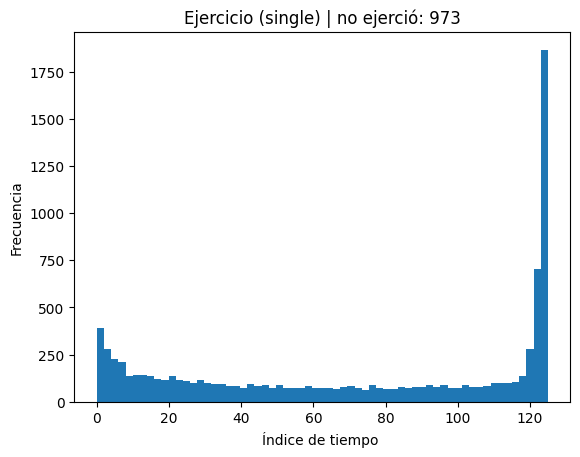

Precio LS (port, put, con mu): 5.024886946023881


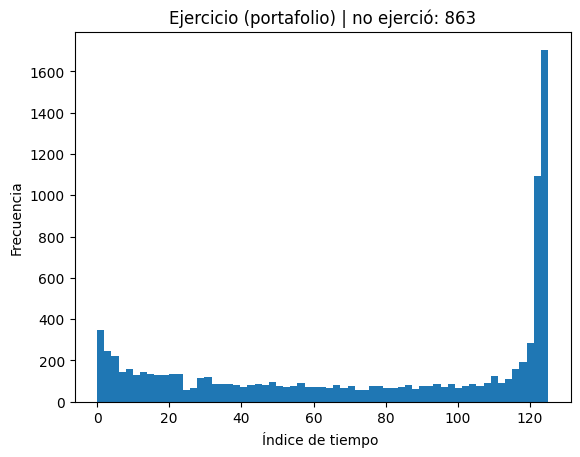

Precio Binomial (single, call): 25.408052536146233
Precio Binomial (port, call): 29.098877451047205


In [ ]:
if __name__ == "__main__":
    ticker1 = "AAPL"
    ticker2 = "SBUX"
    fecha_inicio = "2021-01-01"
    fecha_fin = "2022-03-31"

    r = 0.06
    dt_days = 1
    T_days = 252 / 2
    num_sims = 10000
    grados_pasado = 2

    # strike ejemplo como tú
    K = ultimo_precio(ticker1, fecha_inicio, fecha_fin)

    # --- LS single (simulación con mu histórica) ---
    precio, ejercicios = calcula_precio_americana(
        ticker1, fecha_inicio, fecha_fin,
        num_sims=num_sims, dt_days=dt_days, T_days=T_days,
        funcion_payoff=payoff_put, K=K, grados_pasado=grados_pasado,
        r=r, seed=123
    )
    print("Precio LS (single, put, con mu):", precio)
    plot_hist_ejercicio(ejercicios, T_days, "Ejercicio (single)")

    # --- LS portafolio (simulación con mu histórica) ---
    w = 0.7
    K1 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
    K2 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
    Kp = w * K1 + (1 - w) * K2

    precio_p, ejercicios_p = calcula_precio_americana_port(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims=num_sims, dt_days=dt_days, T_days=T_days,
        funcion_payoff=payoff_put, K=Kp, grados_pasado=grados_pasado,
        r=r, seed=123
    )
    print("Precio LS (port, put, con mu):", precio_p)
    plot_hist_ejercicio(ejercicios_p, T_days, "Ejercicio (portafolio)")

    # --- Binomial sola ---
    precio_bin = arbol_americano(
        ticker1, fecha_inicio, fecha_fin,
        K=170, T_years=1.0, r=r, N=100, tipo="call"
    )
    print("Precio Binomial (single, call):", precio_bin)

    # --- Binomial port ---
    K_port_bin = (K1 + K2) / 2
    precio_bin_port = arbol_americano_portafolio(
        ticker1, ticker2, w, fecha_inicio, fecha_fin,
        K=K_port_bin, T_years=1.0, r=r, N=100, tipo="call"
    )
    print("Precio Binomial (port, call):", precio_bin_port)
